In [ ]:
!pip install yfinance -q
!pip install statsmodels==0.13.2 -q

     |████████████████████████████████| 62 kB 779 kB/s 
     |████████████████████████████████| 9.8 MB 6.1 MB/s 


In [ ]:
import statsmodels
from math import sqrt
import numpy as np
from numpy import mean
from numpy import median
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import  Holt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib as mpl

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

print(mpl.__version__)  
print(sns.__version__)
%matplotlib inline

3.2.2
0.11.2


In [ ]:
df = pd.DataFrame(yf.Ticker('^GSPC').history(period="max"))
df['date'] = df.index
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
Date,,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0,1950-01-03
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0,1950-01-04
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0,1950-01-05
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0,1950-01-06
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0,1950-01-09
...,...,...,...,...,...,...,...,...
2022-08-11,4227.399902,4257.910156,4201.410156,4207.270020,3925060000,0,0,2022-08-11
2022-08-12,4225.020020,4280.470215,4219.779785,4280.149902,3252290000,0,0,2022-08-12
2022-08-15,4269.370117,4301.790039,4256.899902,4297.140137,3087740000,0,0,2022-08-15


In [ ]:
sp500Month = df.Close
sp500Month.index = pd.to_datetime(df.index)
sp500Month = sp500Month.resample('1M').mean()

In [ ]:
train_size = int(len(sp500Month) * 0.9) 
train, test = train_test_split(sp500Month, train_size=train_size, shuffle=False)

In [ ]:
months = pd.date_range(start='2022-08-31', end='2023-08-31', freq='M')

In [ ]:
def getScores(test, forecast):
  mse = mean_squared_error(test, forecast)
  print('MSE: '+str(np.round(mse, 2)))

  mae = mean_absolute_error(test, forecast)
  print('MAE: '+str(np.round(mae, 2)))

  rmse = np.sqrt(mean_squared_error(test, forecast))
  print('RMSE: '+str(np.round(rmse, 2)))

  mape = mean_absolute_percentage_error(test, forecast) * 100
  print('MAPE: '+str(np.round(mape, 2)))

## **Jednostavno Eksponencijalno izravnanje**

In [ ]:
simpleModel = SimpleExpSmoothing(train)
simpleModel = simpleModel.fit(optimized=True)
yhat_simple = simpleModel.forecast(len(test))

Prognoza

In [ ]:
simpleModel = SimpleExpSmoothing(sp500Month)
simpleModel = simpleModel.fit(optimized=True)
yhat_simple_forecast = simpleModel.forecast(len(months))

Vizuelizacija

(array([708205., 711858., 715510., 719163., 722815., 726468., 730120.,
        733773., 737425., 741078.]),
 <a list of 10 Text major ticklabel objects>)

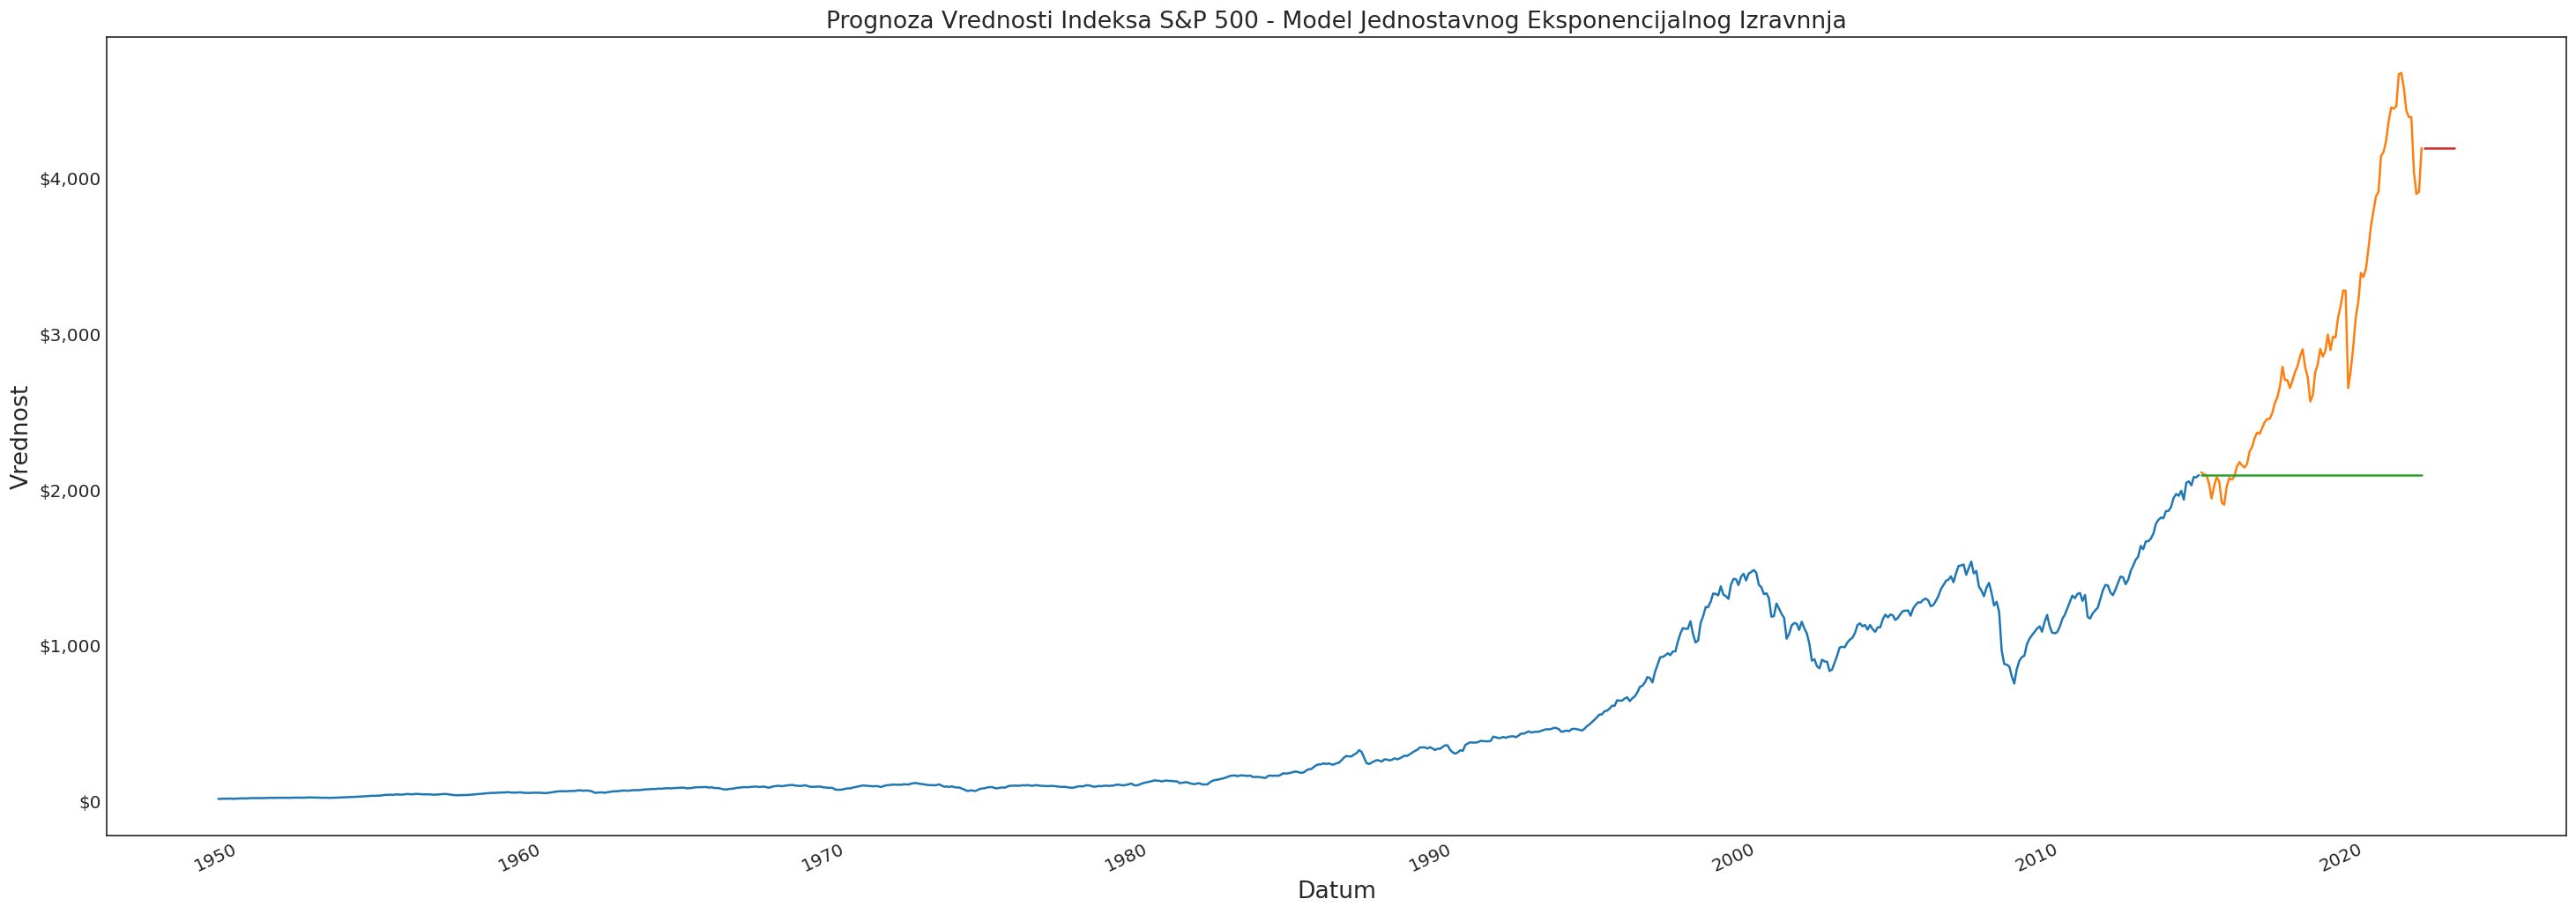

In [ ]:
fig, ax  = plt.subplots(figsize=(30,10), dpi=120)

ax.plot(train, label="Trening")
ax.plot(test, label="Test")
ax.plot(yhat_simple, label="Predikcija")
ax.plot(yhat_simple_forecast, label="Prognoza")

ax.set_title("Prognoza Vrednosti Indeksa S&P 500 - Model Jednostavnog Eksponencijalnog Izravnnja")
ax.set_xlabel("Datum")
ax.set_ylabel("Vrednost")

ax.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

Performanse

In [ ]:
mse = mean_squared_error(test, yhat_simple)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, yhat_simple)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, yhat_simple))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, yhat_simple)
print('MAPE: '+str(mape))

MSE: 1431141.5548373198
MAE: 906.8094501914373
RMSE: 1196.3032871464159
MAPE: 0.2586806589564833


**HOLTOV MODEL**

In [ ]:
holt_model = ExponentialSmoothing(train, trend="add",seasonal=None, use_boxcox=True).fit(remove_bias=True)
yhat_holt = holt_model.forecast(steps=len(test))

Prognoza

In [ ]:
holt_model_forecast = ExponentialSmoothing(sp500Month, trend="add",seasonal=None, use_boxcox=True).fit( remove_bias=True)
yhat_holt_forecast = holt_model_forecast.forecast(steps=len(months))

In [ ]:
holt_model.params

{'smoothing_level': 0.9999999850988388,
 'smoothing_trend': 2.4135507278913668e-17,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 2.5739753210749305,
 'initial_trend': 0.004378894974445773,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': True,
 'lamda': -0.06589922100221027,
 'remove_bias': True}

Vizuelizacija

(array([725737., 727198., 728659., 730120., 731581., 733042., 734503.,
        735964., 737425., 738886., 740347.]),
 <a list of 11 Text major ticklabel objects>)

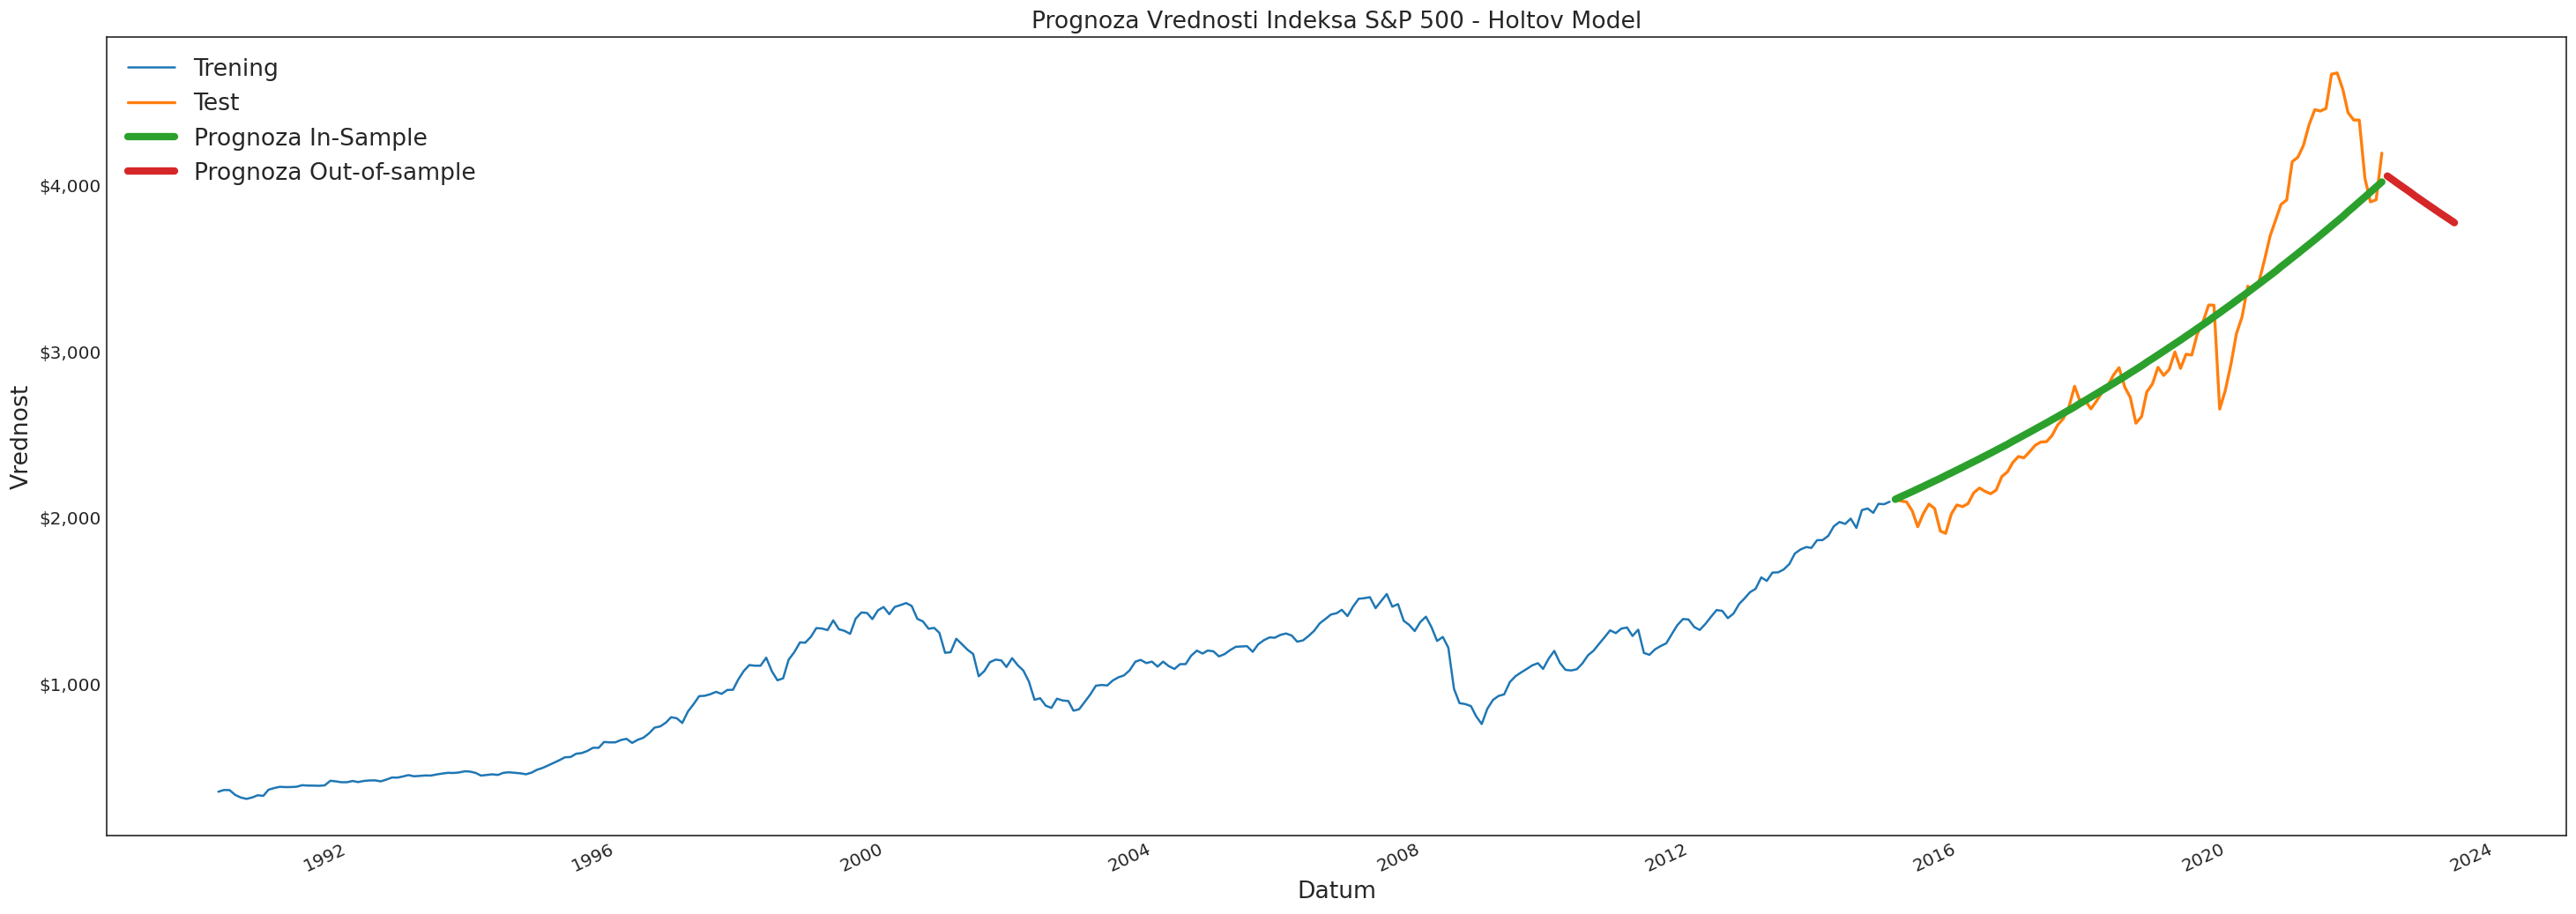

In [ ]:
fig, ax  = plt.subplots(figsize=(30,10), dpi=120)
ax.plot(train[-300:], label="Trening")
ax.plot(test, label="Test",  linewidth=2)
ax.plot(yhat_holt, label="Predikcija", linewidth=5)
ax.plot(yhat_holt_forecast, label="Prognoza", linewidth=5)

ax.legend(["Trening", "Test", "Prognoza In-Sample", "Prognoza Out-of-sample"])
ax.set_title("Prognoza Vrednosti Indeksa S&P 500 - Holtov Model")
ax.set_xlabel("Datum")
ax.set_ylabel("Vrednost")

ax.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

Performanse

In [ ]:
mse = mean_squared_error(test, yhat_holt)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, yhat_holt)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, yhat_holt))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, yhat_holt)
print('MAPE: '+str(mape))

MSE: 102592.76768887111
MAE: 227.9757367499149
RMSE: 320.3010578953356
MAPE: 0.07211847179958314


In [ ]:
yhat_holt_forecast

2022-09-30    4055.727424
2022-10-31    4031.532788
2022-11-30    4007.489375
2022-12-31    3983.596197
2023-01-31    3959.852271
2023-02-28    3936.256624
2023-03-31    3912.808286
2023-04-30    3889.506297
2023-05-31    3866.349701
2023-06-30    3843.337550
2023-07-31    3820.468902
2023-08-31    3797.742821
2023-09-30    3775.158378
Freq: M, dtype: float64

**HOLT WINTERS**

In [ ]:
exp_model = ExponentialSmoothing(train, trend="add",seasonal="add", use_boxcox=True).fit(remove_bias=True)
yhat_exp = exp_model.forecast(steps=len(test))
exp_model.params

{'smoothing_level': 0.9999999850988387,
 'smoothing_trend': 0.0,
 'smoothing_seasonal': 1.1570551150900987e-08,
 'damping_trend': nan,
 'initial_level': 2.5771370480997473,
 'initial_trend': 0.004375883530679754,
 'initial_seasons': array([-0.00314102, -0.00313042, -0.00266601,  0.00128888,  0.00099406,
        -0.00230844, -0.00353501, -0.00623968, -0.01099563, -0.0163148 ,
        -0.01333374, -0.00913259]),
 'use_boxcox': True,
 'lamda': -0.06589922100221027,
 'remove_bias': True}

Prognoza

In [ ]:
exp_model_forecast = ExponentialSmoothing(sp500Month, trend="mul",seasonal="add", use_boxcox=True).fit()
yhat_exp_forecast = exp_model_forecast.forecast(steps=len(months))

Vizuelizacija

(array([708205., 711858., 715510., 719163., 722815., 726468., 730120.,
        733773., 737425., 741078.]),
 <a list of 10 Text major ticklabel objects>)

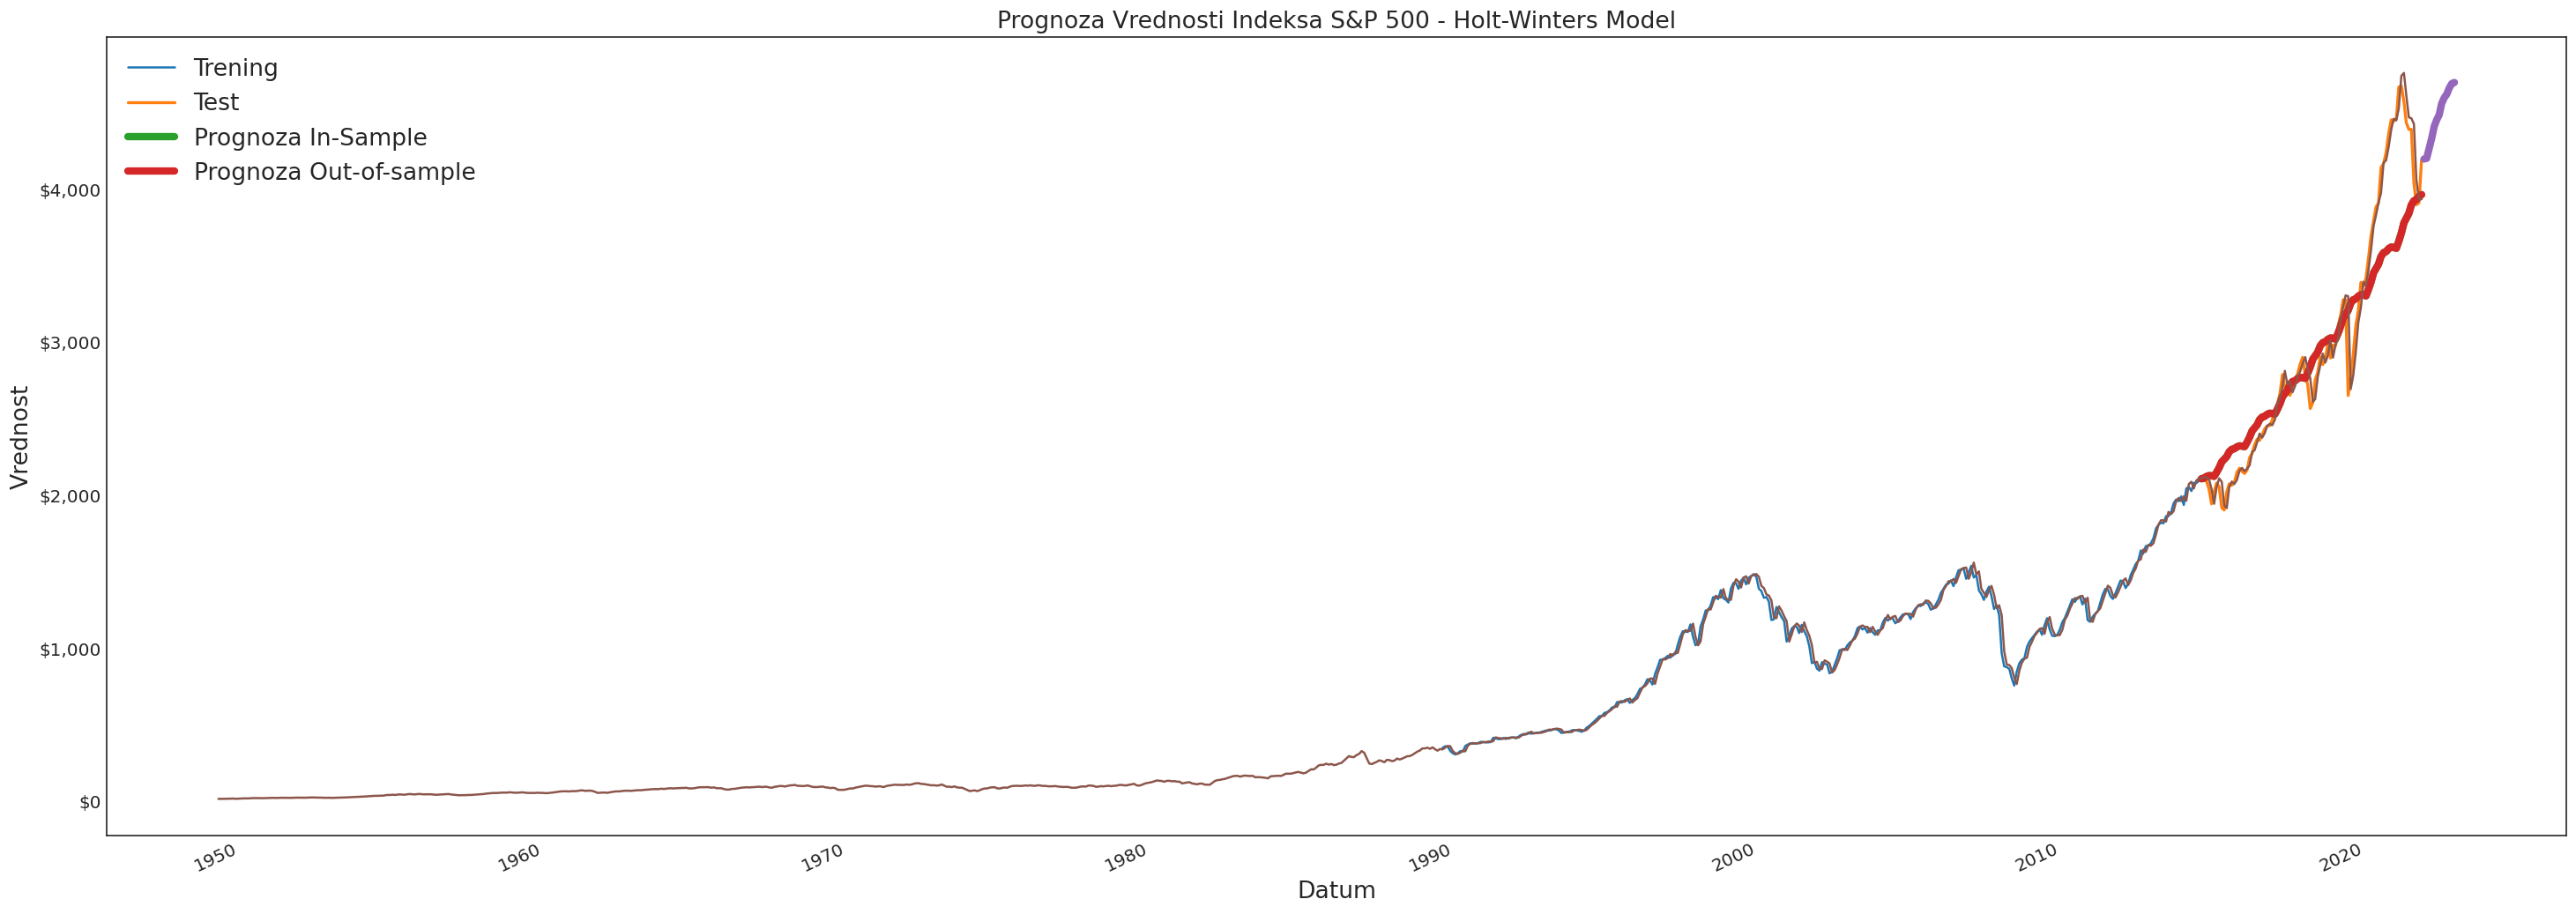

In [ ]:
fig, ax  = plt.subplots(figsize=(30,10), dpi=120)

ax.plot(train[-300:], label="Trening")
ax.plot(test, label="Test",  linewidth=2)
ax.plot(yhat_exp, label="Predikcija",  linewidth=5)
ax.plot(yhat_exp, label="Predikcija",  linewidth=5)
ax.plot(yhat_exp_forecast, label="Prognoza",  linewidth=5)
ax.plot(exp_model_forecast.fittedvalues, label="Prognoza")

ax.legend(["Trening", "Test", "Prognoza In-Sample", "Prognoza Out-of-sample"])

ax.set_title("Prognoza Vrednosti Indeksa S&P 500 - Holt-Winters Model")
ax.set_xlabel("Datum")
ax.set_ylabel("Vrednost")

ax.tick_params(axis='both', labelsize=12)
fmt = '${x:,.0f}'

tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
plt.xticks(rotation=25)

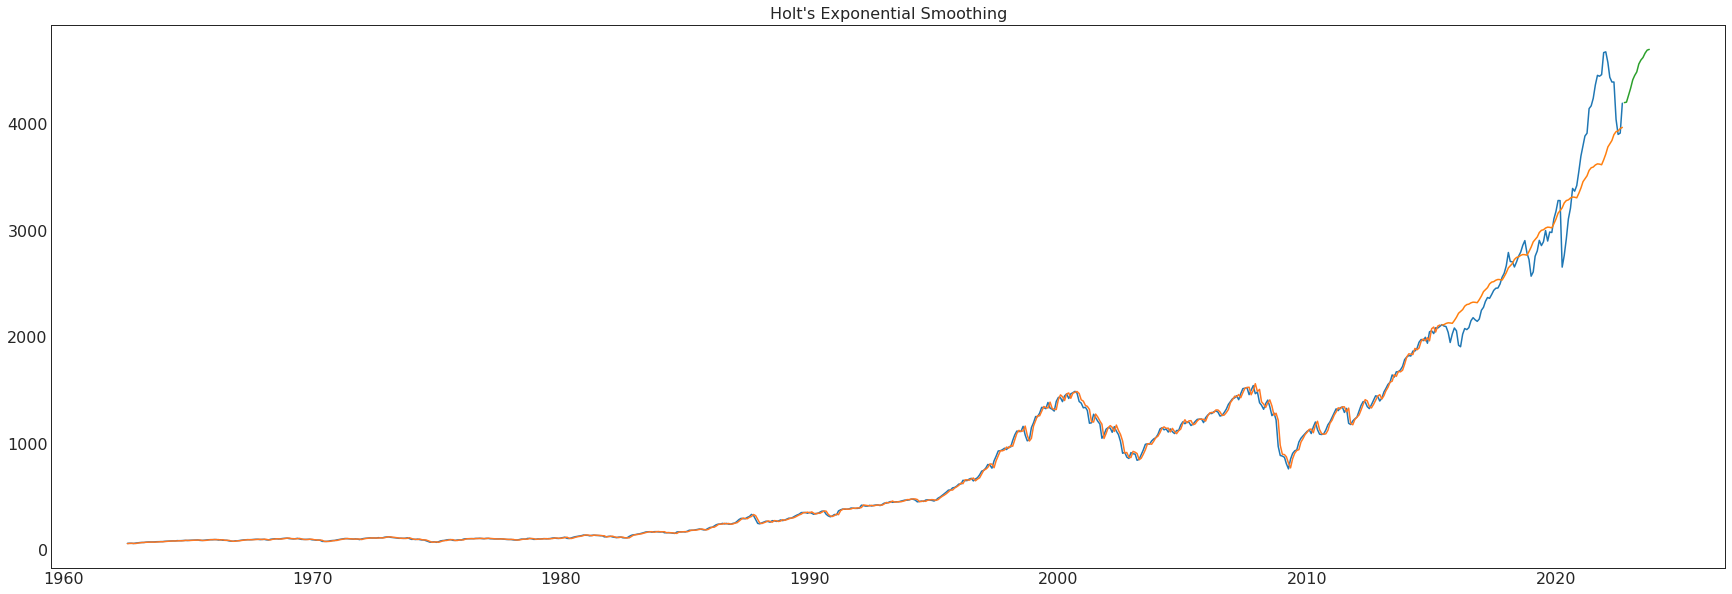

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(sp500Month.index[150:], sp500Month.values[150:])

ax.plot(train.index[150:], exp_model.fittedvalues[150:], color='#ff7823')
ax.plot(yhat_exp)
ax.plot(yhat_exp_forecast)
plt.title("Holt's Exponential Smoothing")
plt.legend();

Performanse

In [ ]:
mse = mean_squared_error(test, yhat_exp)
print('MSE: '+str(mse))

mae = mean_absolute_error(test, yhat_exp)
print('MAE: '+str(mae))

rmse = np.sqrt(mean_squared_error(test, yhat_exp))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test, yhat_exp)
print('MAPE: '+str(mape))

MSE: 110405.30042929431
MAE: 227.52363596170164
RMSE: 332.27293062976753
MAPE: 0.06978787508115965


In [ ]:
yhat_exp_forecast

2022-09-30    4140.873811
2022-10-31    4141.029731
2022-11-30    4199.922315
2022-12-31    4261.314826
2023-01-31    4333.959249
2023-02-28    4368.635802
2023-03-31    4397.238368
2023-04-30    4465.195734
2023-05-31    4497.064143
2023-06-30    4515.173359
2023-07-31    4550.428016
2023-08-31    4573.598920
2023-09-30    4574.492782
Freq: M, dtype: float64

In [ ]:
getScores(test, yhat_exp)

MSE: 110405.3
MAE: 227.52
RMSE: 332.27
MAPE: 6.98


## **Eksperiment sa različitim parametrima - Holtov model**

In [ ]:
def get_future_dates(start_date, into_future, offset=1):
  start_date = start_date + np.timedelta64(offset, "M") 
  end_date = start_date + np.timedelta64(into_future, "M")
  return np.arange(start_date, end_date, dtype="datetime64[M]")

In [ ]:
INTO_FUTURE = 12

In [ ]:
last_timestep = sp500Month.index[-1]
last_timestep

Timestamp('2022-08-31 00:00:00', freq='M')

In [ ]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02',
       '2023-03', '2023-04', '2023-05', '2023-06', '2023-07', '2023-08'],
      dtype='datetime64[M]')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  


{'smoothing_level': 0.3, 'smoothing_trend': 0.05, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 16.65863967378933, 'initial_trend': 0.27346131018959113, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


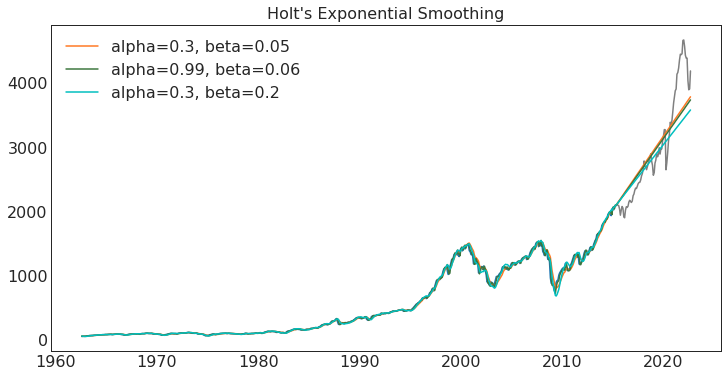

In [ ]:
model = Holt(train)
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(len(test))
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(len(test))
fit3 = model.fit(smoothing_level=.3, smoothing_slope=.2)
pred3 = fit3.forecast(len(test))
print(fit1.params)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index[150:], train.values[150:])
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

In [ ]:
print("1")
getScores(test, pred1)
print("2")
getScores(test, pred2)
print("3")
getScores(test, pred3)

1
MSE: 146032.62
MAE: 284.77
RMSE: 382.14
MAPE: 0.09
2
MSE: 154477.57
MAE: 283.75
RMSE: 393.04
MAPE: 0.09
3
MSE: 197524.37
MAE: 302.2
RMSE: 444.44
MAPE: 0.09


In [ ]:
fit2.params

{'smoothing_level': 0.9954999985098839,
 'smoothing_trend': 0.06399642847563539,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 16.81399559747605,
 'initial_trend': 0.23034453619094036,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  


{'smoothing_level': 0.7, 'smoothing_trend': 0.05, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 16.60601957755875, 'initial_trend': 0.27678674013257715, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


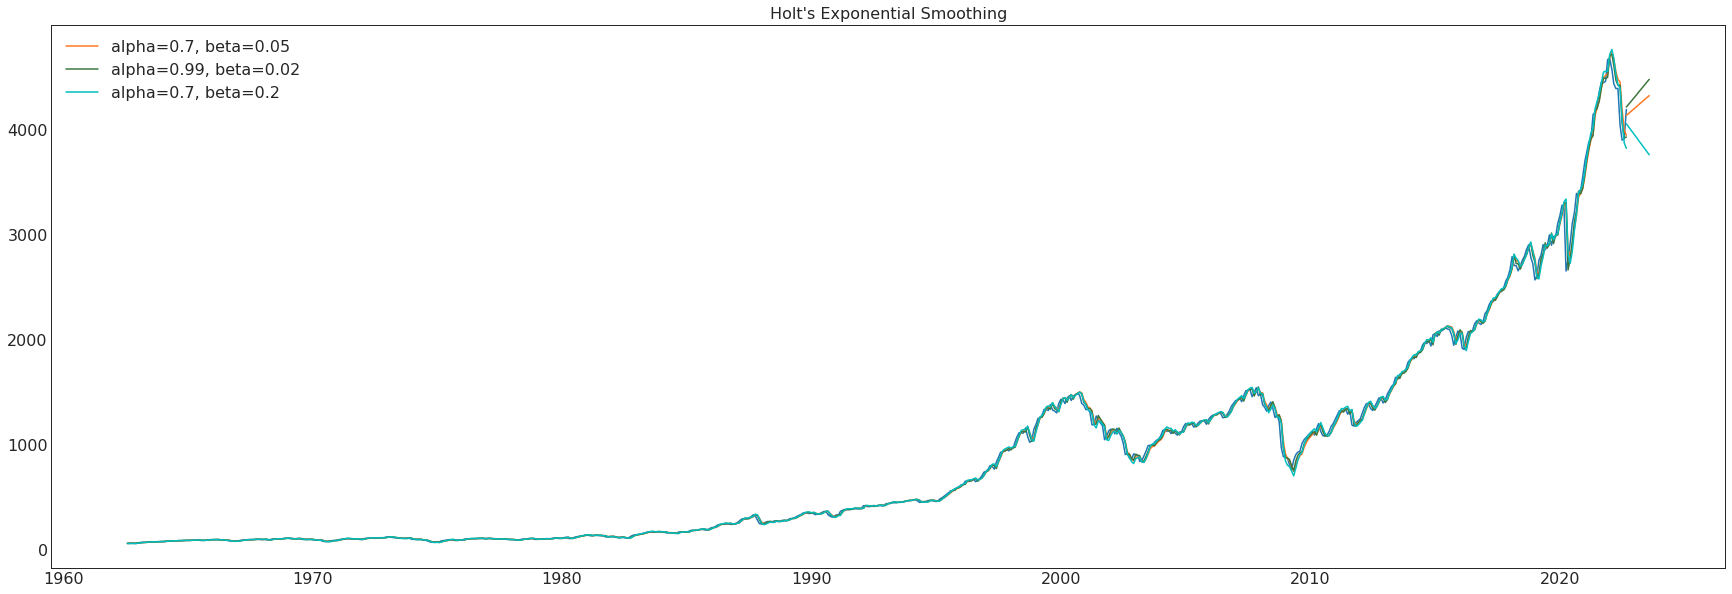

In [ ]:
model = Holt(sp500Month)
model._index = pd.to_datetime(sp500Month.index)

fit1 = model.fit(smoothing_level=.7, smoothing_slope=.05)
pred1 = fit1.forecast(12)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(12)
fit3 = model.fit(smoothing_level=.7, smoothing_slope=.2)
pred3 = fit3.forecast(12)
print(fit1.params)

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(sp500Month.index[150:], sp500Month.values[150:])
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(sp500Month.index[150:], f.fittedvalues[150:], color=c)
    ax.plot(next_time_steps, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_trend'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();